# Assignment1: PyTorch Classification
* Cifar10 dataset에 대해 정확도 97% 이상의 Classifier를 만드세요
* 코드 수정 가능 (단, 첫 번째 cell은 건드리지 말 것)
* Hint. 모델 디자인 뿐만 아니라 transfer learning, batch size 및 learning rates 조절, data augmentation 등을 통해 분류기 정확도를 높일 수 있음. (https://pytorch.org/vision/stable/transforms.html)
* 단, transfer learning 사용 시, cifar10에 학습된 모델을 사용하는 것은 금지함.

## 아래 코드는 Shallow CNN을 사용한 예시 코드입니다.
* 바로 아래 위치한 셀은 수정하시면 안됩니다.

In [4]:
from matplotlib import pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import numpy as np
import time
import copy
from torchvision.models import efficientnet_b2
# Do not touch codes below!
# These codes control random seed for reproduction
seed = 7777

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### Dataset CIFAR10 download

In [5]:
img_dir = './CIFAR10'

transform = transforms.Compose([
    transforms.Resize(260),  # EfficientNet-B2의 입력 크기에 맞게 조정
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CIFAR-10 데이터셋 로딩
cifar10_train = datasets.CIFAR10(img_dir, train=True,
                                        download=True, transform=transform)
cifar10_test = datasets.CIFAR10(img_dir, train=False,
                                       download=True, transform=transform)
dataloader_train = DataLoader(cifar10_train, batch_size=16,  # 배치 크기 증가
                                          shuffle=True, num_workers=2)
dataloader_test = DataLoader(cifar10_test, batch_size=16,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


#### Check images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

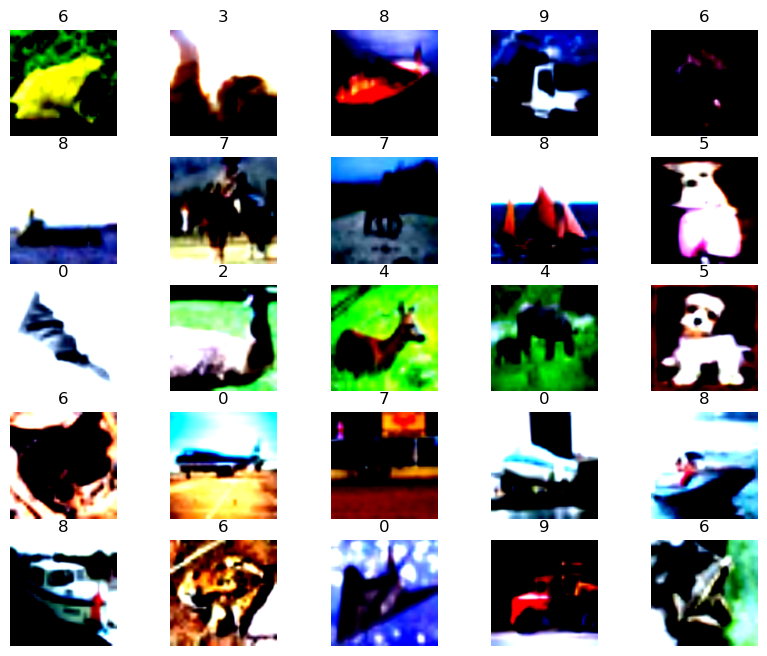

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cifar10_train), size=(1,)).item()
    img, label = cifar10_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0).squeeze(), cmap="gray")
plt.show()

#### Transfer learning by EfficientnetB2
-EfficientnetB7이 가장 성능이 뛰어난 것으로 알려져있으나, GPU 메모리 부족으로 불가능함.

In [6]:
# 모델 로드 및 조정
model = efficientnet_b2(pretrained=True)
# CIFAR-10 클래스 수(10)에 맞게 마지막 분류층 조정
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)

/home/piai/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/piai/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Train

In [8]:
# 손실 함수 및 최적화
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
i# Train the model
num_epochs = 20
model_best = None
acc_best = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for i, (images, labels) in enumerate(dataloader_train):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, preds = torch.max(output, 1)
        loss = loss_func(output, labels)
        # clear gradients for this training step
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        # backpropagation, compute gradients
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(cifar10_train)
    epoch_acc = running_corrects.double() / len(cifar10_train)
    print ('Epoch [{}/{}], Train -> Loss: {:.4f}, Acc: {:.4f}'
                   .format(epoch + 1, num_epochs, epoch_loss, epoch_acc))
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader_test):
            images = images.to(device)
            labels = labels.to(device)
            # Inference
            output = model(images)
            _, preds = torch.max(output, 1)
            # Calculate loss
            loss = loss_func(output, labels)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
    # 통계값
    epoch_loss = running_loss / len(cifar10_test)
    epoch_acc = running_corrects.double() / len(cifar10_test)
    print ('Epoch [{}/{}], Valid -> Loss: {:.4f}, Acc: {:.4f}'
               .format(epoch + 1, num_epochs, epoch_loss, epoch_acc))
    # Fine the best model
    if acc_best < epoch_acc:
        acc_best = epoch_acc
        model_best = copy.deepcopy(model)

Epoch [1/20], Train -> Loss: 0.4863, Acc: 0.8498
Epoch [1/20], Valid -> Loss: 0.1418, Acc: 0.9532
Epoch [2/20], Train -> Loss: 0.1817, Acc: 0.9405
Epoch [2/20], Valid -> Loss: 0.1093, Acc: 0.9649
Epoch [3/20], Train -> Loss: 0.1179, Acc: 0.9611
Epoch [3/20], Valid -> Loss: 0.0949, Acc: 0.9689
Epoch [4/20], Train -> Loss: 0.0858, Acc: 0.9711
Epoch [4/20], Valid -> Loss: 0.0853, Acc: 0.9727
Epoch [5/20], Train -> Loss: 0.0653, Acc: 0.9784
Epoch [5/20], Valid -> Loss: 0.0795, Acc: 0.9753
Epoch [6/20], Train -> Loss: 0.0504, Acc: 0.9838
Epoch [6/20], Valid -> Loss: 0.0837, Acc: 0.9746
Epoch [7/20], Train -> Loss: 0.0385, Acc: 0.9872
Epoch [7/20], Valid -> Loss: 0.0849, Acc: 0.9744
Epoch [8/20], Train -> Loss: 0.0312, Acc: 0.9892
Epoch [8/20], Valid -> Loss: 0.0859, Acc: 0.9747
Epoch [9/20], Train -> Loss: 0.0286, Acc: 0.9916
Epoch [9/20], Valid -> Loss: 0.0843, Acc: 0.9756
Epoch [10/20], Train -> Loss: 0.0238, Acc: 0.9925
Epoch [10/20], Valid -> Loss: 0.0977, Acc: 0.9731
Epoch [11/20], Tra

#### Test

In [10]:
model_best.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        
        # Inference
        test_output = model_best(images)

        # Calculate error
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0) 
    accuracy = correct / total * 100
    
print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 97.65 Percent


#### Save the model checkpoint

In [11]:
torch.save(model_best.state_dict(), '김한탁_trained_model_efficientNet_B2.pkl')

#### Load the trained model and test

In [10]:
model_load = model.to(device)
model_load.load_state_dict(torch.load('김한탁_trained_model_efficientNet_B2.pkl'))

model_load.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        images = images.to(device)
        labels = labels.to(device)
        
        # Inference
        test_output = model_load(images)

        # Calculate error
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0) 
    accuracy = correct / total * 100
    
print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 97.65 Percent


# Try your own codes!
* 과제로 제출한 checkpoint를 'torch.load' 및 'torch.load_state_dict'를 사용해 불러온 후, accuracy를 측정할 예정입니다.
* 위의 Save 및 Load 코드를 기반으로 여러분이 직접 학습한 모델의 checkpoint가 잘 동작하는지 확인하시기 바랍니다.